### Implementation of Content-based Filtering

In [1]:
import pandas as pd
import numpy as np
import time
import math
from math import sqrt
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from xgboost import XGBRegressor
import pickle

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
random.seed(42)


In [2]:
data_folder = 'Dataset/'
user_item_ratings_reduced = pd.read_csv(f'{data_folder}user_ratings_reduced.csv')
user_item_ratings_reduced = user_item_ratings_reduced.drop(columns=["Unnamed: 0"])
item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
item_info = pd.read_csv(data_folder + 'games.csv')
item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
item_themes = pd.read_csv(data_folder + 'themes.csv')

In [3]:
# user_item_ratings_reduced['rating'] = user_item_ratings_reduced['rating'].round(0).astype(int)

In [4]:
user_item_rating_count = user_item_ratings_reduced.groupby('user').count()

In [5]:
min_rating_count = 10
user_rating_count = user_item_rating_count[user_item_rating_count['rating'] >= min_rating_count]
user_list_filtered = list(user_rating_count.index)
user_item_ratings_filtered = user_item_ratings_reduced[user_item_ratings_reduced['user'].isin(user_list_filtered)]

In [6]:
user_item_ratings_filtered.head()

,item,rating,user
1,203416,8.0,-=Yod@=-
2,271896,8.0,-=Yod@=-
3,38054,6.0,-=Yod@=-
4,312267,5.0,-=Yod@=-
5,68448,9.0,-=Yod@=-


### Preprocessing

In [7]:
# item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
# item_info = pd.read_csv(data_folder + 'games.csv')
# item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
# item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
# item_themes = pd.read_csv(data_folder + 'themes.csv')

In [8]:
item_info.rename(columns={'BGGId':'item'},inplace=True)
# get comeplete user-catalog data
user_item_complete = pd.merge(user_item_ratings_filtered, item_info, on='item', how='inner')
# item_info.info() 
# item_info[['GoodPlayers', 'Family', 'ImagePath']].head()
non_numerical_features = ['user','Name','Description', 'item', 'GoodPlayers', 'Family', 'ImagePath']

In [9]:
user_item_complete.columns

Index(['item', 'rating', 'user', 'Name', 'Description', 'YearPublished',
       'GameWeight', 'AvgRating', 'BayesAvgRating', 'StdDev', 'MinPlayers',
       'MaxPlayers', 'ComAgeRec', 'LanguageEase', 'BestPlayers', 'GoodPlayers',
       'NumOwned', 'NumWant', 'NumWish', 'NumWeightVotes', 'MfgPlaytime',
       'ComMinPlaytime', 'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings',
       'NumComments', 'NumAlternates', 'NumExpansions', 'NumImplementations',
       'IsReimplementation', 'Family', 'Kickstarted', 'ImagePath',
       'Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts',
       'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames',
       'Rank:partygames', 'Rank:childrensgames', 'Cat:Thematic',
       'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract',
       'Cat:Party', 'Cat:Childrens'],
      dtype='object')

In [10]:
# find a median rating for each user
median_rating = user_item_complete.groupby('user')['rating'].median().rename('median_rating').reset_index()
user_item_complete = pd.merge(user_item_complete, median_rating, on='user', how='inner')

In [11]:
user_item_complete.shape

(1228331, 51)

User-Item matrix has size (1_228_331, 51) after selecting users with >= `min_rating_count`

User-Item matrix has size (771_551, 51) after selecting items for users with rating higher than their mean rating

In [12]:
# creating user represenations
user_item_favourite = user_item_complete[user_item_complete['rating']>=user_item_complete['median_rating']]

user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)

user_representation = user_item_favourite.groupby('user').median().reset_index()
user_representation_wnames = user_representation['user']
user_representation.drop(columns=['user'], inplace=True)
user_item_favourite.drop(columns=non_numerical_features, inplace=True)

/var/folders/hc/hnq3mts53txg3k7xbmj90z_80000gn/T/ipykernel_11748/2750365072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
/var/folders/hc/hnq3mts53txg3k7xbmj90z_80000gn/T/ipykernel_11748/2750365072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)
/var/folders/hc/hnq3mts53txg3k7xbmj90z_80000gn/T/ipykernel_11748/2750365072.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. I

In [13]:
user_representation.shape

(51149, 45)

### Analysis of user preference clusters
 > based on TSNE clusterings of users with similar preferences, several groups of users were investigated to check if there are differences in prederences between clusters. The analysis showed that all the groups have approximately similar preferences. Hence, no need to create different features per user group

In [14]:
def get_all_items_for_user(username, complete_df):
    return complete_df[complete_df['user']==username].drop(columns=['user'])

In [15]:
def add_avg_group_rating(selected_items, group, complete):
    selected_items.reset_index(drop=True, inplace=True)
    selected_items['avg_group_rating'] = 0
    group_users = group['user'].unique()
    for index,item in selected_items.iterrows():
        item_in_group = complete[(complete['user'].isin(group_users))&(complete['item']==item['item'])]
        average_group_rating = item_in_group['rating'].mean()
        item['avg_group_rating'] = average_group_rating
        selected_items.iloc[index,:] = item
        
    return selected_items


In [16]:
all_users = pd.merge(user_representation, user_representation_wnames,left_index=True, right_index=True, how='left')
all_items = add_avg_group_rating(user_item_complete.sample(frac=0.005, random_state=42), all_users, user_item_complete)

In [17]:
def save(obj):
    def get_variable_name(var):
        # Iterate over the global variables
        for name, value in globals().items():
            if value is var:
                return name
        return None
    name = get_variable_name(obj)
    with open(name+".pkl", "wb") as f: # "wb" because we want to write in binary mode
        pickle.dump(obj, f)
        
def open(path):
    return pickle.loads(path)

In [18]:
def test_stat_significance(feature_name, selected_items):
    """ test whether an item feature has statistically significant 
        correlation (Pearson) with a group rating
    """

    feature = selected_items[feature_name].dropna()
    ratings = selected_items['avg_group_rating'].reindex(feature.index).values
    feature = feature.values
    
    r, p = pearsonr(ratings, feature)
    
    significant = False
    if p < 0.05:
        significant = True

    # print(f'feature {feature_name} has p-value {round(p,2)}, significant: {significant}, correlation: {round(r,2)}')
    return r, significant


In [19]:
def find_group_features(group_items, complete):
    features = group_items.columns
    group_features = []
    for feature_name in features:
        if feature_name in non_numerical_features:
            continue
        
        correlation, significant = test_stat_significance(feature_name, group_items)
        
        if significant and abs(correlation) > 0.10:
            group_features.append(feature_name)
    return group_features

In [20]:
sign_user_preferences = set(find_group_features(all_items, user_item_complete))

/Users/Vitalij/Desktop/RecSys Project/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [21]:
rating_features = ['AvgRating', 'BayesAvgRating', 'StdDev', 'avg_group_rating', 'median_rating']

### Item Features for Content-Based Filtering
- the features which have correlation with an average rating more than 0.15 in absolute values
- are not rating features
- are statistically significant


The features (19) were received:
```
 'Rank:boardgame',
 'Rank:strategygames',
 'Rank:childrensgames',
 'Rank:partygames',

 'NumWant',
 'NumWish',
 'NumUserRatings',
 'NumOwned',
 'NumWeightVotes',

 'BestPlayers',
 'GameWeight',
 'ComAgeRec',
 'Kickstarted',
 'MinPlayers',
 'LanguageEase',
 'MfgAgeRec'

 'Cat:Party',
 'Cat:Childrens',
 'Cat:Strategy',
 ```

Based on the analysis of the correlation of similar features from the list, the following were discarded:

 `'NumWish', 'NumWeightVotes'`

In [22]:
final_item_features = [f for f in (list(sign_user_preferences) + ['item','user']) if f not in rating_features + ['NumWish','NumWeightVotes']]

In [23]:
mechanics_features = ['mechanic_' + i if not i == 'BGGId' else i for i in item_mecahnics.columns]
subcategory_features = ['subcategory_' + i if not i == 'BGGId' else i for i in item_subcategories.columns]
theme_features = ['theme_' + i.split('_')[-1] if not i == 'BGGId' else i for i in item_themes.columns]

item_mecahnics.columns = mechanics_features
item_subcategories.columns = subcategory_features
item_themes.columns = theme_features

item_catalog = pd.merge(item_mecahnics, item_subcategories, on='BGGId', how='outer')
item_catalog = pd.merge(item_catalog, item_themes, on='BGGId', how='outer')

In [24]:
user_item_selected = user_item_complete[final_item_features]
user_item_all_features = pd.merge(user_item_selected, item_catalog, left_on='item', right_on='BGGId', how='left')

In [25]:
user_item_all_features.select_dtypes(include=['object']).columns

Index(['user'], dtype='object')

In [26]:
all_user_names = user_item_all_features.user.unique()

In [182]:
user_item_all_features[final_item_features][user_item_all_features['item']==5467]

,ComMaxPlaytime,MfgAgeRec,LanguageEase,NumExpansions,Kickstarted,Rank:boardgame,Rank:strategygames,rating,Rank:childrensgames,Rank:partygames,...,GameWeight,ComAgeRec,NumWant,MinPlayers,Cat:Party,ComMinPlaytime,NumUserRatings,MfgPlaytime,item,user
227086,45,8,NaN,0,0,10921,21926,5.0,21926,21926,...,1.875,NaN,8,3,0,45,175,45,5467,BoardGameDude
333010,45,8,NaN,0,0,10921,21926,8.0,21926,21926,...,1.875,NaN,8,3,0,45,175,45,5467,Aquafan
442881,45,8,NaN,0,0,10921,21926,7.0,21926,21926,...,1.875,NaN,8,3,0,45,175,45,5467,KlausScharpf
808612,45,8,NaN,0,0,10921,21926,6.0,21926,21926,...,1.875,NaN,8,3,0,45,175,45,5467,Disneyphile
1046734,45,8,NaN,0,0,10921,21926,6.0,21926,21926,...,1.875,NaN,8,3,0,45,175,45,5467,Snowy0505
1174991,45,8,NaN,0,0,10921,21926,8.0,21926,21926,...,1.875,NaN,8,3,0,45,175,45,5467,caffeinatedgamer


In [141]:
def generate_Xy_for_user(username, complete_df):
    scaler = StandardScaler()
    user_rated_items = complete_df[complete_df['user']==username]
    index_x = user_rated_items.index
    X = user_rated_items.drop(columns=['user','rating', 'item'])
    normalized_matrix = scaler.fit_transform(X)
    X =  pd.DataFrame(normalized_matrix, columns=X.columns, index=index_x)
    y = user_rated_items['rating']
    return X,y

In [28]:
# X,y = generate_Xy_for_user(all_user_names[0],user_item_all_features[final_item_features])
# train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2, random_state=42)

In [29]:
# svr = SVR(kernel='linear')
# svr.fit(train_X, train_y)

In [30]:
# predicted_y = svr.predict(test_X)

In [31]:
# item_rating = test_y.to_frame().copy()
# item_rating['predicted'] = predicted_y

### Evaluation

In [32]:
# num_users_test = 1
# users_for_test = random.sample(list(all_user_names), num_users_test)

In [33]:
# ((item_rating['rating']-item_rating['predicted'])**2).mean(0)**0.5

In [34]:
# (abs(item_rating['rating']-item_rating['predicted'])).mean(0)

In [35]:
# def evaluate_users(users, user_item_all_features, regressor):
#     RMSEs = []
#     MAEs = []
#     for user in users:
#         X,y = generate_Xy_for_user(user,user_item_all_features)
#         train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
#
#         regressor.fit(train_X, train_y)
#         predicted_y = regressor.predict(test_X)
#
#         item_ratings = test_y.to_frame().copy()
#         item_ratings['predicted'] = predicted_y
#
#         RMSEs.append(((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5)
#         MAEs.append((abs(item_ratings['rating']-item_ratings['predicted'])).mean(0))
#
#     return RMSEs, MAEs

In [36]:
# user_item_all_features['ComAgeRec'].fillna(value=user_item_all_features['ComAgeRec'].mean(), inplace=True)
# user_item_all_features['LanguageEase'].fillna(value=user_item_all_features['LanguageEase'].mean(), inplace=True)

In [37]:
# regressor = SVR(kernel='linear')
# RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [38]:
# avg_RMSE = np.mean(RMSEs)
# avg_MAE = np.mean(MAEs)

In [39]:
# print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

In [40]:
# regressor = DecisionTreeRegressor()
# RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [41]:
# avg_RMSE = np.mean(RMSEs)
# avg_MAE = np.mean(MAEs)
# print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

In [42]:
# regressor = XGBRegressor()
# RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [43]:
# avg_RMSE = np.mean(RMSEs)
# avg_MAE = np.mean(MAEs)
# print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

In [44]:
# all_user_names

In [45]:
# user_item_all_features[final_item_features]

In [46]:
# test_X.iloc[0]

In [47]:
# user_item_ratings_filtered.shape

# Group Recommender System

## Dividing users in to groups
Groups are made by looking at the most similar users
The features are aggregated by addition strategy

In [48]:
user_item_ratings_filtered.head()

,item,rating,user
1,203416,8.0,-=Yod@=-
2,271896,8.0,-=Yod@=-
3,38054,6.0,-=Yod@=-
4,312267,5.0,-=Yod@=-
5,68448,9.0,-=Yod@=-


In [49]:
from synthetic_groups_generation.groups_generators import GroupsGenerator

user_matrix = user_item_ratings_filtered.pivot_table(columns='item', index='user', values='rating')

In [50]:
user_matrix= user_matrix.iloc[:30000]

item,1,2,3,4,5,6,7,8,9,10,...,345584,345976,346482,346501,346703,346965,347146,347521,348955,349131
user,,,,,,,,,,,,,,,,,,,,,
-=Yod@=-,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Johnny-,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-mIDE-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-toni-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...Hammer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
user_id_set = set(user_matrix.index.values)
user_id_indexes = user_matrix.index

In [52]:
user_matrix = user_matrix.fillna(0)

In [54]:
# user_matrix.to_csv("user_matrix.csv")

In [55]:
# user_matrix = pd.read_csv("user_matrix.csv")

In [57]:
# user_matrix = user_matrix.iloc[:1000]

In [59]:
numpy_array = user_matrix.to_numpy()

In [60]:
sim_matrix = np.corrcoef(numpy_array[:][1:])

Text(0.5, 0, "Pearson's Correlation Coeficient")

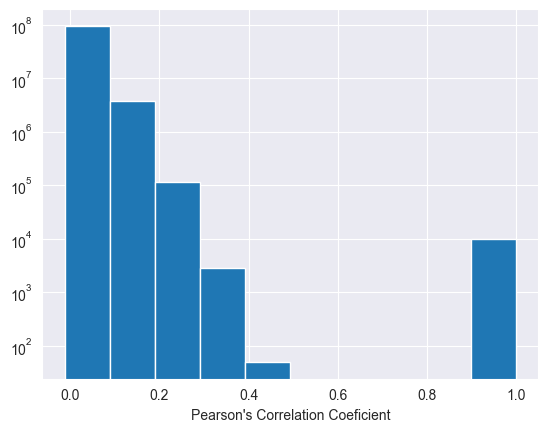

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sim_matrix.flatten())
plt.yscale("log")
plt.xlabel("Pearson's Correlation Coeficient")

In [74]:
grpGenerator = GroupsGenerator.getGroupsGenerator("SIMILAR")
current_list = grpGenerator.generateGroups(user_id_indexes, user_id_set, sim_matrix, [4], 250)

display(pd.DataFrame.from_records(current_list))
groups = pd.DataFrame.from_records(current_list)

250


,group_size,group_similarity,group_members,avg_similarity
0,4,similar,"[BoardGameDude, EnumahElish, Cidade Curiosa, H...",0.258208
1,4,similar,"[Eggrocket, Friedrich, AngryWeaseL, Foo Dog]",0.216405
2,4,similar,"[DiddyWahDiddy, Cheelara1, Gummidoc, GordonHua]",0.249129
3,4,similar,"[Eladamri2, Darkhorse27, Donie, Elchotizogrande]",0.196199
4,4,similar,"[Bogusgig, Frootshoot, DoctahSeuss, DaCaRo]",0.218832
...,...,...,...,...
245,4,similar,"[1x0r, EYE of NiGHT, Frost1981, El Capitano]",0.232521
246,4,similar,"[Camelorn, David Tagliaferri, Gregarius, Hyper...",0.266938
247,4,similar,"[Dj Silent Bob, Erlaad, Ascalante, Eclectic Mi...",0.214637
248,4,similar,"[Gwfalcon, 22764636, EastridgeT, Deltacustom]",0.219983


In [153]:
groups_ratings = pd.DataFrame(columns=final_item_features)

# For each group aggregate ratings
for i in range(len(groups)):
    # Get group members usernames
    selected_users = groups.iloc[i]["group_members"]

    # Create a dataframe for particular group
    group_ratings = pd.DataFrame(columns=final_item_features)
    # Append their ratings
    for user in selected_users:
        selected_users_rating = user_item_all_features[user_item_all_features["user"]==user][final_item_features]
        group_ratings= pd.concat([group_ratings,selected_users_rating], axis=0)

    # Aggregation if duplicates are found
    duplicated_items = group_ratings[group_ratings['item'].duplicated(keep=False)]
    item_set = set(duplicated_items.item)
    for item in item_set:
        group_ratings = group_ratings.drop(group_ratings[group_ratings["item"] == item].index)
        duplicated_items['rating'] = duplicated_items[duplicated_items['item']==item]['rating'].mean()
        duplicated_items = duplicated_items.iloc[[0]]
        group_ratings = pd.concat([group_ratings,duplicated_items], axis=0)

    group_ratings['user'] = i
    groups_ratings = pd.concat([groups_ratings, group_ratings], axis=0)

In [183]:
groups_ratings = groups_ratings.fillna(0)

In [176]:
group_names = groups_ratings['user'].unique()

In [178]:
group_names[0]

0

## Making a group recommender system using SVR

In [190]:
X,y = generate_Xy_for_user(group_names[0],groups_ratings)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2, random_state=42)

In [191]:
group_svr = SVR(kernel='linear')
group_svr.fit(train_X, train_y)

SVR(kernel='linear')

In [192]:
predicted_y = group_svr.predict(test_X)
item_rating = test_y.to_frame().copy()
item_rating['predicted'] = predicted_y

In [193]:
item_rating

,rating,predicted
227086,5.00,6.509308
494149,7.00,7.562722
494151,8.00,8.427332
494194,7.00,5.962354
227072,6.00,7.530112
494144,7.00,6.380447
494167,7.50,7.492719
1193736,7.50,5.947606
494135,7.00,7.441563
494160,7.00,7.441480


In [194]:
groups_ratings.to_csv("group_ratings.csv")